## Basic Statistical Analysis
The purpose of performing statistical analysis is to 'clean' our data set

In [93]:
import glob
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats

from helper_functions import cm_to_inch 

In [86]:
FILE_NUMBER = 0
USER = 'TP_5. prekomorske brigade_PLC_13555150_A+_15201'

In [39]:
# for example data replace the argument in glob.glob to 'example_data/*xlsx'
data_set = glob.glob('data/*xlsx')
print('Number of files: {}'.format(len(data_set)))

Number of files: 60


In [43]:
df = dict()
for count, data in tqdm(enumerate(data_set)):
    df[count] = pd.read_excel(data, skiprows=[1], skipfooter=1, parse_date=['Time'], index_col='Time')

60it [06:12,  6.21s/it]


In [65]:
def data_completeness(data):
    zero = [value for value in data if value == 0]
    compl = (1 - len(zero) / len(data)) * 100
    return compl

In [54]:
def data_artifact(data):
    data_dc = copy.deepcopy(np.array(data))
    slope = [abs(data_dc[i + 1] - data[i]) for i in range(len(data_dc) - 1)]
    dx = abs(np.diff(data_dc))
    avg_data_dc = np.mean(data_dc)
    avg_dx = np.mean(dx)
    std = np.std(dx)
    for i in range(1, len(data_dc) - 1, 1):
        if data_dc[i] > 20.0 and (abs(data_dc[i] - data_dc[i - 1])) > 10 * avg_dx \
        and (abs(data_dc[i + 1] - data_dc[i])) > 10 * avg_dx:
            data_dc[i] = (data_dc[i - 1] + data_dc[i + 1]) / 2.0
    result = np.where(data_dc < 50.0, data_dc, 0)
    return result

In [106]:
def usability_evaluation(data, complete, compl_max, compl_min, compl_avg, compl_std):
    pos_of_usable_series = list()
    n = 0
    for pos in tqdm(data):
        for name in data[pos]:
            time_series = data_artifact(data[pos][name])
            complete.append(data_completeness(time_series))
            # complete.append(data_completeness(data[pos][name]))
            if complete[n] > 90.0:
                pos_of_usable_series.append(n)
                compl_max.append(sorted(np.delete(time_series, np.where(time_series == 0)))[-1])
                compl_min.append(sorted(np.delete(time_series, np.where(time_series == 0)))[1])
                compl_avg.append(np.mean(time_series))
                compl_std.append(np.std(time_series))
            n += 1
            
    return pos_of_usable_series

In [114]:
def get_usable_time_series(data, usable_list):
    n = 0
    series = {}
    for pos in data:
        for name in data[pos]:
            if n in usable_list:
                series[name] = data[pos][name]
        n += 1
    return series          

In [107]:
compl = []
compl_max = []
compl_min =  []
compl_avg = []
compl_std = []
usable = usability_evaluation(df, compl, compl_max, compl_min, compl_avg, compl_std)







  0%|                                                                                           | 0/60 [00:00<?, ?it/s]





  2%|█▍                                                                                 | 1/60 [00:21<21:31, 21.89s/it]





  3%|██▊                                                                                | 2/60 [00:23<15:09, 15.68s/it]





  5%|████▏                                                                              | 3/60 [00:25<11:14, 11.83s/it]





  7%|█████▌                                                                             | 4/60 [00:28<08:31,  9.13s/it]





  8%|██████▉                                                                            | 5/60 [00:33<07:06,  7.76s/it]





 10%|████████▎                                                                          | 6/60 [00:37<05:57,  6.63s/it]





 12%|█████████▋                                                                         | 7/60 [00:45<06:20,  7.19s/it]

In [90]:
plt.style.use(['seaborn'])
plt.rcParams["font.family"] = "Times new roman"
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

Text(0, 0.5, '<E>_h [kWh]')

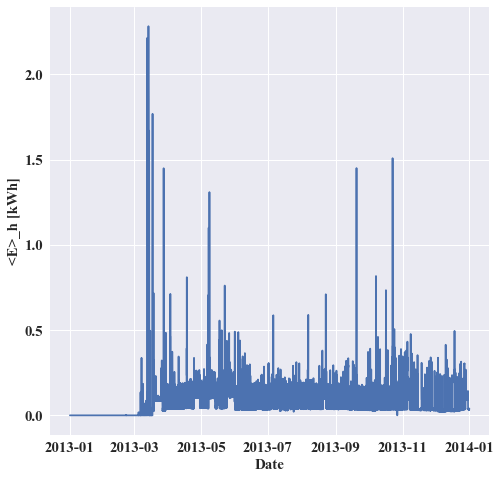

In [91]:
plt.figure(figsize=(cm_to_inch(20), cm_to_inch(20)))
plt.plot(df[FILE_NUMBER].index, df[FILE_NUMBER][USER])
plt.xlabel('Date', fontsize=15)
plt.ylabel('<E>_h [kWh]', fontsize=15)

Text(0, 0.5, 'N')

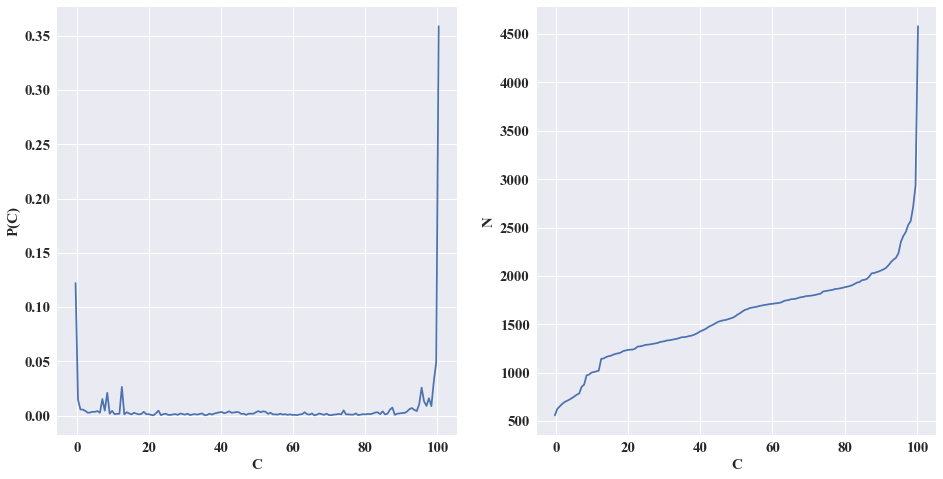

In [94]:
plt.figure(figsize = (cm_to_inch(40), cm_to_inch(20)))
res1 = stats.relfreq(compl, numbins = 150)
res2 = stats.cumfreq(compl, numbins = 150)

x = res1.lowerlimit + np.linspace(0, res1.binsize * res1.frequency.size, res1.frequency.size)
y = res2.lowerlimit + np.linspace(0, res2.binsize * res2.cumcount.size, res2.cumcount.size) 


plt.subplot(121)
plt.plot(x, res1.frequency)
plt.xlabel('C', fontsize = 15)
plt.ylabel('P(C)', fontsize = 15)

plt.subplot(122)
plt.plot(y, res2.cumcount)
plt.xlabel('C', fontsize = 15)
plt.ylabel('N', fontsize = 15)

In [98]:
relative_std = list()
for i in range(len(compl_std)):
    relative_std.append(compl_std[i] / compl_avg[i])

Text(0, 0.5, 'avg E [kWh]')

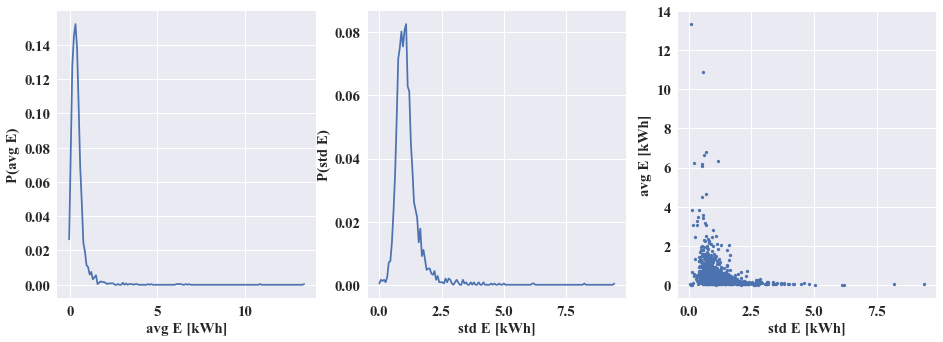

In [101]:
plt.figure(figsize = (cm_to_inch(40), cm_to_inch(13.4)))

res1 = stats.relfreq(compl_avg, numbins = 150)
x = res1.lowerlimit + np.linspace(0, res1.binsize * res1.frequency.size, res1.frequency.size)

plt.subplot(131)
plt.plot(x, res1.frequency)
plt.xlabel('avg E [kWh]', fontsize = 15)
plt.ylabel('P(avg E)', fontsize = 15)

res1 = stats.relfreq(relative_std, numbins = 150)
x = res1.lowerlimit + np.linspace(0, res1.binsize * res1.frequency.size, res1.frequency.size)

plt.subplot(132)
plt.plot(x, res1.frequency)
plt.xlabel('std E [kWh]', fontsize = 15)
plt.ylabel('P(std E)', fontsize = 15)

plt.subplot(133)
plt.scatter(relative_std, compl_avg, s = 9)
plt.xlabel('std E [kWh]', fontsize = 15)
plt.ylabel('avg E [kWh]', fontsize = 15)

## Extract usable time series to excel
This data will be needed for future data manipulation

In [ ]:
users = get_usable_time_series(df, usable)
users = pd.DataFrame.from_dict(users)
users.to_excel('usable_users.xlsx')